In [1]:
#%matplotlib
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib as mpl
from qutip import *
mpl.rcParams['figure.dpi'] = 150

In [78]:
eigenenergies = qload('data/instance_5_1/eigenenergies');
eigenvectors = qload('data/instance_5_1/eigenvectors')
slist = np.linspace(0,1,51)

Loaded ndarray object.
Loaded list object.


## Create Exact Cover problem

In [204]:
name = 'instance_5_1_simple'
mat = spio.loadmat('../../Matlab/matqaoa/jeppesen_instances_simple/' + name + '.mat')
instance = mat['instance']
eigvals = instance['eigvals']
num_q = instance['size'][0][0][0][0]
J = -instance['J'][0][0] # MINUS SIGN IS IMPORTANT
h = -np.array(instance['h'][0][0]).flatten() 
costs = np.array(eigvals[0][0]).flatten()

In [2]:
num_q = 2 # Number of qubits
J = np.array([[0,-1/2],[0,0]])
h = np.array([-1/2,0])

## Define system parameters

In [205]:
num_lvl = 12 # number of levels in Hilbert space
K = 1 # amplitude of Kerr nonlinearity
G = 4 # amplitude of two-photon drive
alpha = pow(G/K,1/2) # amplitude of coherent state
F = h/(2 * alpha) # amplitude of single-photon drives
delta = 1 # amplitude of dephasing

# Construct Hamiltonians

In [213]:
a = destroy(num_lvl) # annihilation operator
eye = qeye(num_lvl) # identity operator

# Computational basis
up = coherent(num_lvl,alpha) # |↑⟩ → |0⟩
down = coherent(num_lvl,-alpha) # |↓⟩ → |1⟩

# Initial Hamiltonian
H_i = 0
# Final Hamiltonian
H_p = 0
for q in range(num_q):
    b = tensor([a if q==j else eye for j in range(num_q)]) # annihilation operator for the q:th qubit
    H_i += - delta * b.dag() * b - K * pow(b.dag(),2) * pow(b,2)
    H_p += - K * pow(b.dag(),2) * pow(b,2) + G * (pow(b.dag(),2) + pow(b,2)) + F[q] * (b.dag() + b)
    if q < (num_q-1) and J[q][q+1] != 0:
        c = tensor([a if (q+1)==j else eye for j in range(num_q)]) # annihilation operator for the q:th qubit
        g = J[q][q+1]/pow(alpha,2)
        H_int = g * (b.dag() * c + c.dag() * b)
        H_i += H_int
        H_p += H_int 

# time dependent factor for the initial Hamiltonian
def H_i_coeff(t, args):
    tau = args['tau']
    return (1 - t/tau)

# time dependent factor for the final Hamiltonian
def H_p_coeff(t,args):
    tau = args['tau']
    return t/tau

# total Hamiltonian
H_tot = [[H_i,H_i_coeff],[H_p, H_p_coeff]]

### Wigner function test

([<matplotlib.axis.YTick at 0x7fd13df62460>,
 <a list of 3 Text major ticklabel objects>)

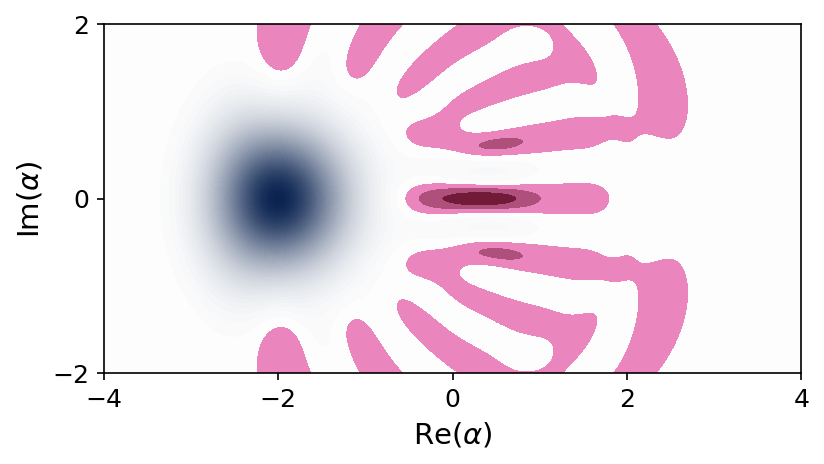

In [78]:
eigenstates = H_p.eigenstates(eigvals=1,sort='high');
eigenvectors = eigenstates[1]

# find Wigner function
gs = ket2dm(eigenvectors[0])
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W = wigner(gs.ptrace(0), xvec, yvec, 'iterative', 2)
wmap = wigner_cmap(W) # Generate Wigner colormap

# plot Wigner function
plt.subplot(111, aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = wmap)
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

## Evolution of eigenenergies

In [220]:
slist = np.linspace(0,1,51)
eigenenergies = []
eigenvectors = []
for i,s in enumerate(slist):
    H = (1-s)*H_i + s*H_p
    eigenstates = H.eigenstates(sparse=True, sort='high', eigvals=2, tol=0, maxiter=1000)
    eigenenergies.append(eigenstates[0])
    eigenvectors.append(eigenstates[1])
eigenenergies = np.array(eigenenergies)
eigenenergies.tolist();

### Plot eigenenergies

In [91]:
eigenenergies = qload('data/instance_5_1/eigenenergies_2');
eigenvectors = qload('data/instance_5_1/eigenenvectors_2');

Loaded ndarray object.
Loaded list object.


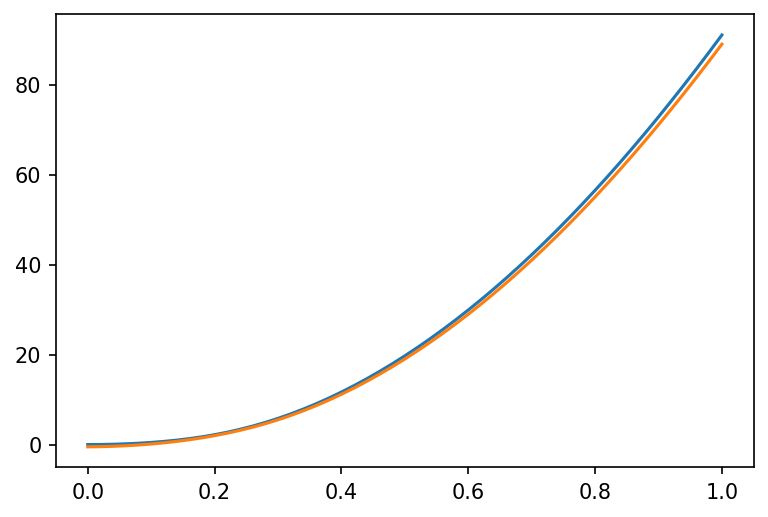

In [221]:
plt.plot(slist,eigenenergies[:,0],'-')
plt.plot(slist,eigenenergies[:,1],'-')
qsave(eigenenergies,'data/instance_5_1/eigenenergies_2')
qsave(eigenvectors,'data/instance_5_1/eigenenvectors_2')

## Find the minimum energy gap
$$\Delta(s) = |E_1(s) - E_0(s)|$$

$$\Delta_\text{min}=\min_s\Delta(s)$$

Text(0, 0.5, '$\\Delta(s)$')

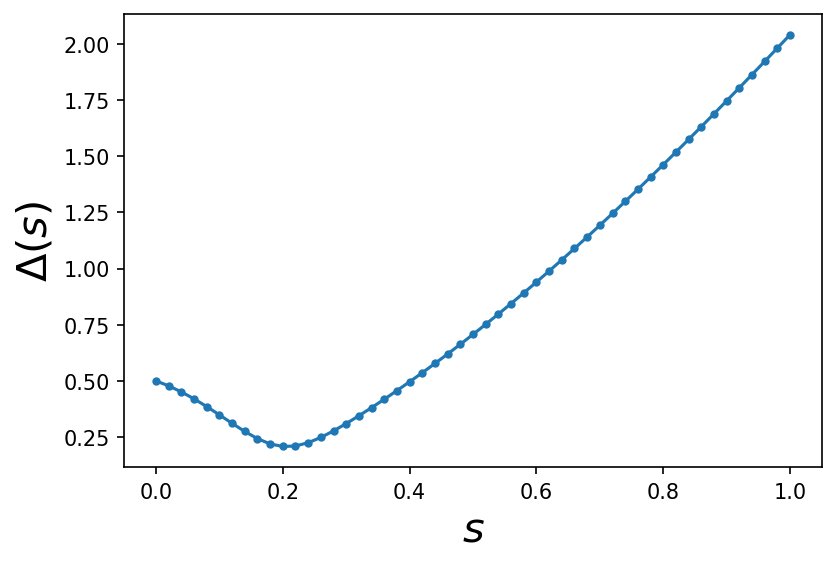

In [222]:
# Minimum energy gap
Delta = abs(eigenenergies[:,1] - eigenenergies[:,0])
Delta_min = min(Delta)
plt.plot(slist,Delta,'.-')
plt.xlabel('$s$',fontsize=20)
plt.ylabel('$\Delta(s)$',fontsize=20)

## Find the matrixelement 
$$H_{10}(s)=|\langle E_1(s) | \frac{dH(s)}{ds} | E_0(s) \rangle |$$

Text(0, 0.5, '$\\langle E_1(s) | \\frac{dH(s)}{ds} | E_0(s) \\rangle$')

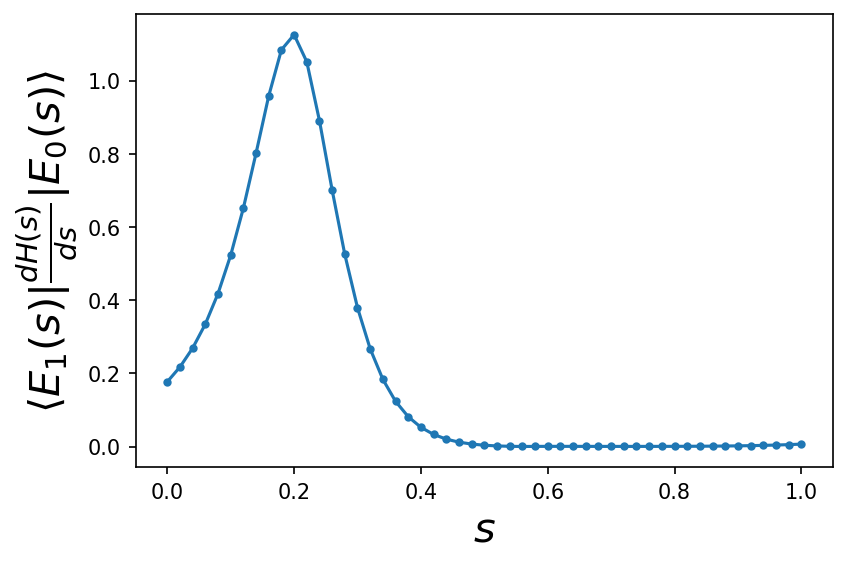

In [223]:
# find max|⟨︀psi_e(s)|dH(s)/ds|psi_g(s)⟩|
overlap = []
for s in range(len(slist)):
    overlap.append(abs((H_p - H_i).matrix_element(eigenvectors[s][1],eigenvectors[s][0])))
    
# Minimum energy gap
plt.plot(slist,overlap,'.-')
plt.xlabel('$s$',fontsize=20)
plt.ylabel(r'$\langle E_1(s) | \frac{dH(s)}{ds} | E_0(s) \rangle$',fontsize=20)

## Adiabatic Condition
$$
T\gg\max_s\frac{|\langle E_1(s) | \frac{dH(s)}{ds} | E_0(s) \rangle |}{\Delta(s)^2}
$$

T >> 26.063731475389265


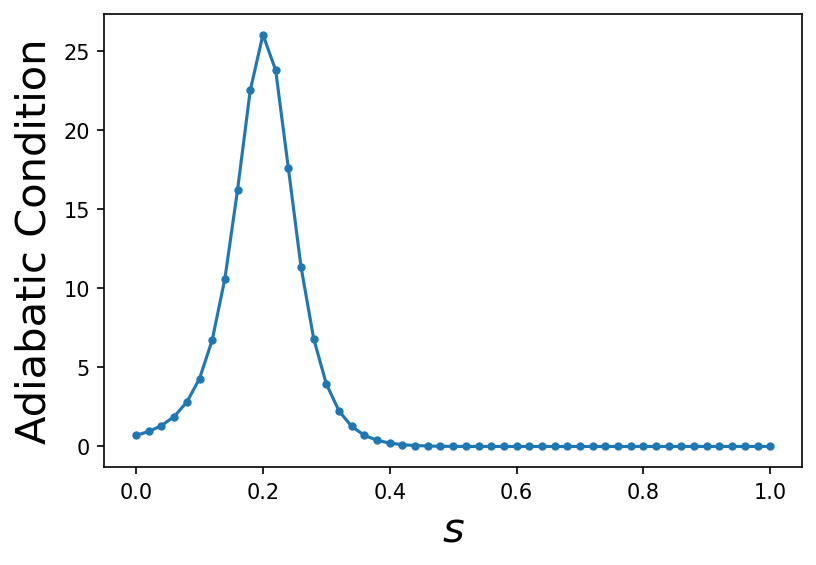

In [224]:
tau = overlap/pow(Delta,2)
T = max(tau)
plt.plot(slist,tau,'.-')
plt.xlabel('$s$',fontsize=20)
plt.ylabel(r'Adiabatic Condition',fontsize=20)

print(r'T >>',T)

In [226]:
T = 26.063731475452183
tlist = np.linspace(0,T,round(T*10))
psi0 = tensor([fock(num_lvl,0) for i in range(num_q)]) # initial state
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8) # for precise calculation
rho = mesolve(H_tot, psi0, tlist, [], args = {'tau': tlist[-1]}, progress_bar = True);
final_state = rho.states[-1] # selects rho(t_final)
qsave(rho,'data/instance_5_1/rho_final')

10.3%. Run time:  65.51s. Est. time left: 00:00:09:27
20.3%. Run time: 131.32s. Est. time left: 00:00:08:35
30.3%. Run time: 190.49s. Est. time left: 00:00:07:18
40.2%. Run time: 253.37s. Est. time left: 00:00:06:16
50.2%. Run time: 428.32s. Est. time left: 00:00:07:05
60.2%. Run time: 662.65s. Est. time left: 00:00:07:18
70.1%. Run time: 879.49s. Est. time left: 00:00:06:14
80.1%. Run time: 1100.55s. Est. time left: 00:00:04:33
90.0%. Run time: 1340.30s. Est. time left: 00:00:02:28
Total run time: 1581.26s


In [228]:
target_state = tensor([down,down,down,down,up])
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 57.31 %


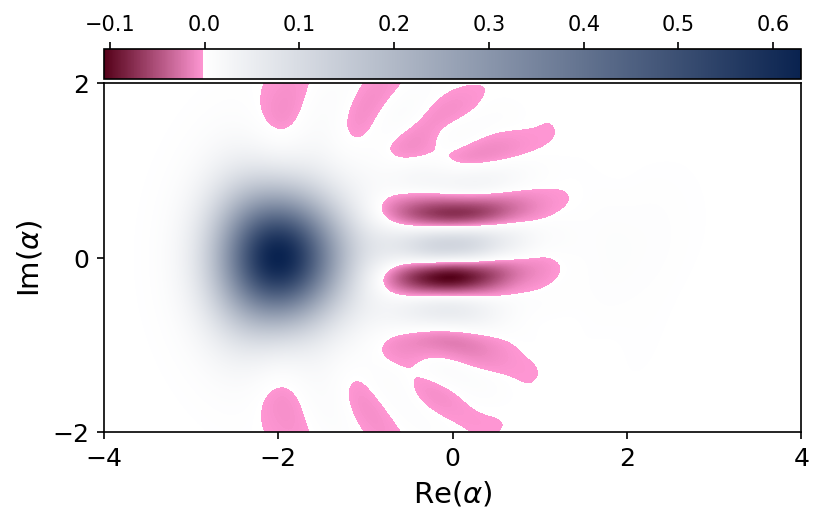

In [234]:
rho_1 = final_state.ptrace(1)

# find Wigner function
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
W = wigner(rho_1, xvec, yvec, 'iterative', 2)
wmap = wigner_cmap(W) # Generate Wigner colormap

# plot Wigner function
plt.subplot(111, aspect='equal')
im = plt.contourf(xvec, yvec, W, 1000, cmap = wmap)
#plt.title('t = %s'r'$\tau$'%(round(t_final/tau,2)))
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min(),1),round(W.max(),1)+0.1,0.1))

plt.show()

## Time to solution

In [49]:
T_max = 21.339402769040568
tlist = np.linspace(0.5,10,100)
psi0 = tensor(fock(num_lvl,0),fock(num_lvl,0)) # initial state
target_state = tensor(down,up)

tts = []
p = []
for T in tlist:
    time = np.linspace(0,T,500)
    rho = mesolve(H_tot, psi0, time, [], args = {'tau': time[-1]}, progress_bar = True);
    final_state = rho.states[-1]

    if final_state.type == 'ket':
        f = (target_state.dag() * final_state).full()[0][0]
        f = abs(f)**2
    else:
        f = abs((target_state.dag() * final_state * target_state).full()[0][0])
    p.append(f)
    tts.append(T * np.log(1-0.99)/np.log(1-f))
    
    

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.11s. Est. time left: 00:00:00:00
90.0%. Run time:   0.12s. Est. time left: 00:00:00:00
Total run time:   0.14s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.11s. Est. time left: 00:00:00:00
90.0%. Run time:   0.13s. Est. time left: 00:00:00:00
Tota

20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.06s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.09s. Est. time left: 00:00:00:00
80.0%. Run time:   0.11s. Est. time left: 00:00:00:00
90.0%. Run time:   0.12s. Est. time left: 00:00:00:00
Total run time:   0.14s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.06s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.09s. Est. time left: 00:00:00:00
80.0%. Run time:   0.11s. Est. time left: 00:00:00:00
90.0%. Run time:   0.12s. Est. time left: 00:00:00:00
Total run time:   0.14s
10.0%. Run time:   0.01s. Est. tim

30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.06s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.09s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.16s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.13s. Est. time left: 00:00:00:00
Total run time:   0.15s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. tim

40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.11s. Est. time left: 00:00:00:00
90.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.16s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.15s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. tim

50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.09s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.16s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.16s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.06s. Est. tim

60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.15s. Est. time left: 00:00:00:00
Total run time:   0.17s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.09s. Est. time left: 00:00:00:00
70.0%. Run time:   0.11s. Est. time left: 00:00:00:00
80.0%. Run time:   0.12s. Est. time left: 00:00:00:00
90.0%. Run time:   0.14s. Est. time left: 00:00:00:00
Total run time:   0.16s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. tim

70.0%. Run time:   0.10s. Est. time left: 00:00:00:00
80.0%. Run time:   0.13s. Est. time left: 00:00:00:00
90.0%. Run time:   0.15s. Est. time left: 00:00:00:00
Total run time:   0.18s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.09s. Est. time left: 00:00:00:00
70.0%. Run time:   0.11s. Est. time left: 00:00:00:00
80.0%. Run time:   0.14s. Est. time left: 00:00:00:00
90.0%. Run time:   0.16s. Est. time left: 00:00:00:00
Total run time:   0.19s
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.09s. Est. tim

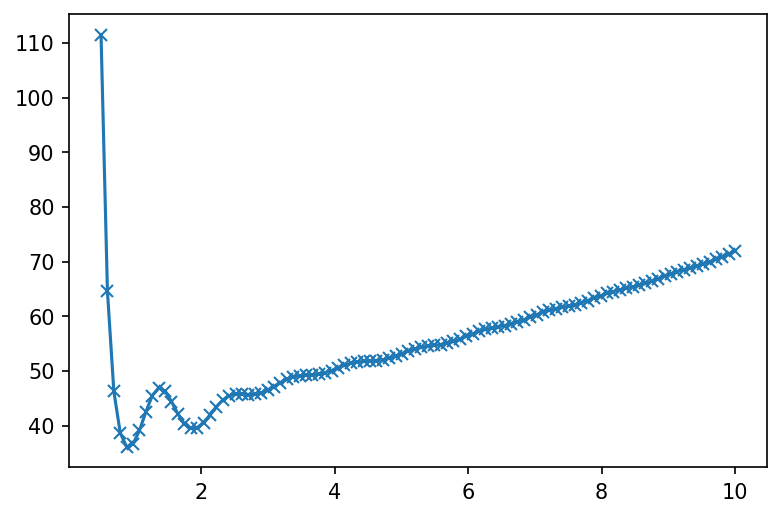

In [50]:
plt.plot(tlist,tts,'x-')